This is some preamble to set up and run this page.

`save_collision_data` will save the collision data, the collision data with GPS only, the weather data grabbed by Big Query and the One Hot Encoded data to their google drive.

`drive` is a boolean set to false to load the user's Google Drive if it does not exist.

`use_bigquery` requires the user to authenticate themselves on Google but will grab the data from a fresh query.

`find_boroughs` takes a while to process, about 15 minutes, and will be required if `use_bigquery` is set to `True`.

If `use_bigquery` and `find_boroughs` are set to `False` then the data will be pulled from presaved `.csv` files.  

In [ ]:
save_collision_data = False 
drive = False
use_bigquery = False
find_borough = False

This is an assignment for Data Analytics on the Web, a short course with the Univesity of the Highlands and Islands. 

This will look at collision data from New York and attempt to fix some of the missing data. As a pretext, some of the missing `borough` data may be missing for a reason, in that it would not exist, but the data being filled in is purely for the exercise.

The collision data will then be combined with data from the weather station in central park to see if weather may have an adverse affect on driving conditions. The purpose of finding the `borough` is to optimise data by finding any correlation that may bias the data by bad driving in a particular neighborhood.

The Machine Learning models used in this particular assignment will be Linear Regression and Neural Networks. 

# Setting up Google
To begin the data will be taken from Google's data warehouse BigQuery, and that requires the user to be signed in.

In [ ]:
if use_bigquery:
  from google.colab import auth
  auth.authenticate_user()
  print('Authenticated')

### Optional: Google Colab Data Table enable 

Google has an optional `google.colab.data_table` function that can be enabled to view large pandas dataframes as interactive tables.

In [ ]:
%load_ext google.colab.data_table

To return to the classic pandas dataframe style then run the next section of code.

In [ ]:
# %unload_ext google.colab.data_table

### Setting up BigQuery
Because this assignment will be drawing its data from BigQuery a project name has to be used.

The project name I have used for my assignment is `uhi-project-20023167`.

*Though I am unsure if following users may have to set up their own unique **cloud console project** to run this code.*

In [ ]:
project_id = 'uhi-project-20023167'

### Making a query

The `bigquery` function will be imported from `google.cloud`. This is to create a `client` object for which to make a query with. The project id declaired above will be assigned, telling BigQuery what project the query is with.

The query itself is made as a string block with SQL syntax. 

In [6]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io
import requests

def get_csv_data(url):
  data = requests.get(url).content
  return pd.read_csv(io.StringIO(data.decode('utf-8')), index_col=0)


if use_bigquery:
  weather_df = pd.io.gbq.read_gbq('''
    SELECT * 
    FROM `uhi-project-20023167.assignment.weather_2012_to_2020`
    ''', project_id=project_id, dialect='standard')

  collision_df = pd.io.gbq.read_gbq('''
    SELECT *
    FROM `uhi-project-20023167.assignment.collision_known`
    ''', project_id=project_id, dialect='standard' )
  
  if find_borough:
    collision_gps_df = pd.io.gbq.read_gbq('''
      SELECT *
      FROM `uhi-project-20023167.assignment.collision_gps_known`
      ''', project_id=project_id, dialect='standard' )
    
    find_borough = True
    
  else:
    # Grab the collision data with the boroughs filled in
    url_gps_collision = 'https://raw.githubusercontent.com/20023167uhi/DataAnalytics/main/Data%20Analytics%20on%20the%20Web/Assignment%201/Data/Tom_Blackwood-Collision_data_gps_Borough_Found_for_New_York_2012-2020.csv'
    collision_gps_df = get_csv_data(url_gps_collision)
  
  
  # collision_unknown_df = pd.io.gbq.read_gbq('''
  #   SELECT *
  #   FROM `uhi-project-20023167.assignment.collision_unknown`
  #   ''', project_id=project_id, dialect='standard' )

  if save_collision_data:
    if not drive:
      from google.colab import drive
      drive.mount('drive')

    weather_df.to_csv('Tom_Blackwood-Weather_data_for_New_York_2012-2020.csv')
    !cp Tom_Blackwood-Weather_data_for_New_York_2012-2020.csv "drive/My Drive"

    half_collision = int((collision_df.index[-1])/2)
    collision_df_pt1 = collision_df[:half_collision].reset_index()
    collision_df_pt2 = collision_df[half_collision + 1:].reset_index()

    collision_df_pt1.to_csv('Tom_Blackwood-Collision_data_known_for_New_York_2012-2020_pt1.csv')
    !cp Tom_Blackwood-Collision_data_known_for_New_York_2012-2020_pt1.csv "drive/My Drive"

    collision_df_pt2.to_csv('Tom_Blackwood-Collision_data_known_for_New_York_2012-2020_pt2.csv')
    !cp Tom_Blackwood-Collision_data_known_for_New_York_2012-2020_pt2.csv "drive/My Drive"
    
    collision_gps_df.to_csv('Tom_Blackwood-Collision_data_gps_known_for_New_York_2012-2020.csv')
    !cp Tom_Blackwood-Collision_data_gps_known_for_New_York_2012-2020.csv "drive/My Drive"

    print("Dataset Successfully Saved!")

else:
  url_weather = 'https://raw.githubusercontent.com/20023167uhi/DataAnalytics/main/Data%20Analytics%20on%20the%20Web/Assignment%201/Data/Tom_Blackwood-Weather_data_for_New_York_2012-2020.csv'
  url_collision_pt1 = 'https://raw.githubusercontent.com/20023167uhi/DataAnalytics/main/Data%20Analytics%20on%20the%20Web/Assignment%201/Data/Tom_Blackwood-Collision_data_known_for_New_York_2012-2020_pt1.csv'
  url_collision_pt2 = 'https://raw.githubusercontent.com/20023167uhi/DataAnalytics/main/Data%20Analytics%20on%20the%20Web/Assignment%201/Data/Tom_Blackwood-Collision_data_known_for_New_York_2012-2020_pt2.csv'

  weather_df = get_csv_data(url_weather)
  collision_df_pt1 = get_csv_data(url_collision_pt1)
  collision_df_pt2 = get_csv_data(url_collision_pt2)

  collision_df = collision_df_pt1.append(collision_df_pt2, ignore_index=True)
  collision_df.set_index('index', inplace=True)
  collision_df.reset_index()

  if find_borough:
    # Grab the collision data without the boroughs filled in
    url_gps_collision = 'https://raw.githubusercontent.com/20023167uhi/DataAnalytics/main/Data%20Analytics%20on%20the%20Web/Assignment%201/Data/Tom_Blackwood-Collision_data_gps_known_for_New_York_2012-2020.csv'
    collision_gps_df = get_csv_data(url_gps_collision)

  else:
    # Grab the collision data with the boroughs filled in
    url_gps_collision = 'https://raw.githubusercontent.com/20023167uhi/DataAnalytics/main/Data%20Analytics%20on%20the%20Web/Assignment%201/Data/Tom_Blackwood-Collision_data_gps_Borough_Found_for_New_York_2012-2020.csv'
    collision_gps_df = get_csv_data(url_gps_collision)
  
  weather_df['date'] = pd.to_datetime(weather_df['date'])
  collision_df['timestamp'] = pd.to_datetime(collision_df['timestamp'])
  collision_gps_df['timestamp'] = pd.to_datetime(collision_gps_df['timestamp'])

main_boroughs_count = collision_df['borough'].value_counts() # Gives count of collisions in each boroughs of the main dataset


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (7,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


The data is created using 3 queries:

Query | Specifying Not `Null` Values Selected | Specifying `Null` Values  Selected
---|---|---
`collision_known`| `borough` |  -
`collision_gps_known` | `longitude`, `latitude`, `location`| `borough` 
`collision_unknown` | `cross_street_name`, `on_street_name`, `off_street_name`|`borough`, `longitude`, `latitude`, `location`

The entry `borough` is the detail sought. Some entries have this detail known, which are gathered for the main dataset. Where the `borough` is unknown two methods are proposed for finding it. The first is using GPS data, `longitude` and `latitude`, to put a name to location using addressing data, and the second would be to create a probability of collisions based on the former datasets where a relationship between `borough` and `*_street_name`. Directly relating `*_street_name` to  `borough` may lead to inconsistencies where a street could run through more than one `borough`.

In [7]:
collision_gps_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356548 entries, 0 to 356547
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   borough            356127 non-null  object        
 1   timestamp          356548 non-null  datetime64[ns]
 2   latitude           356548 non-null  float64       
 3   longitude          356548 non-null  float64       
 4   location           356548 non-null  object        
 5   cross_street_name  49298 non-null   object        
 6   on_street_name     281621 non-null  object        
 7   off_street_name    13435 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 24.5+ MB


In [8]:
collision_gps_df.head()

,borough,timestamp,latitude,longitude,location,cross_street_name,on_street_name,off_street_name
0,MANHATTAN,2020-11-10 22:01:00,40.790253,-73.936850,"(40.790253, -73.93685)",NaN,FDR DRIVE,NaN
1,MANHATTAN,2020-11-29 17:23:00,40.830845,-73.947235,"(40.830845, -73.947235)",NaN,WEST 152 STREET,NaN
2,BROOKLYN,2020-10-25 11:15:00,40.678394,-73.946920,"(40.678394, -73.94692)",NaN,ATLANTIC AVENUE,NaN
3,BROOKLYN,2020-11-13 12:21:00,40.637096,-73.934650,"(40.637096, -73.93465)",NaN,TROY AVENUE,NaN
4,BRONX,2020-09-05 08:10:00,40.826275,-73.859710,"(40.826275, -73.85971)",BRUCKNER BOULEVARD,WHITE PLAINS ROAD,NaN


## Filling in GPS data using the Python Package `uszipcode`

The `borough` column from `collision_gps_*` is completely `null`. To fix these entries, a python package `uszipcode` is used to look up addresses using GPS data. The package `uszipcode` is not naturally available on colab so it must be installed by the cell below.

In [9]:
!pip --quiet install uszipcode 

The SearchEngine object from `uszipcode` is imported and assigned to a variable to be used in a pandas `.apply()` method, which takes the longitude and latitude data, performs a search and returns a list result objects.

The `uszipcode.SearchEngine` allows a search to be performed `by_coordinates`, which takes in a latitude and longitude by `lat` and `lng`, performs a search within a `radius`, in miles, and can return a specified number of results. The results are returns as a list result objects, and the first one is selected with `[0]` which holds the details about that partiuclar 'closest' zip code. From the results, the `major_city` element of the object will largely find the borough but it sometimes finds neighbourhoods of the boroughs. For this lists of the neighbourhoods have been created to filter the result into their appropriate borough. 

The returned `major_city` or filtered `borough` will be in string format, which will be useful for encoding the counts of collisions later.

If no `major_city` objects are returned then the function below returns a `None` with, which will be dropped later using a function as that data will be considered unusuable. (Possibly due to instrumentation error or a response outwith the GPS domain of New York.) 

There may be a better/quicker way to do this.

*(if running, it will take a while. Feel free to fetch that second cup of tea...)*

In [10]:
from uszipcode import SearchEngine

search = SearchEngine(simple_zipcode=True) # set simple_zipcode=True to not use rich info database

STATEN_ISLE_loc = ["Staten Island", "Annadale", "Arden Heights", "Arlington", "Arrochar", "Bay Terrace", "Bloomfield", 
                   "Brighton Heights", "Bulls Head", "Castleton Corners", "Charleston", "Chelsea", "Clifton", 
                   "Concord", "Dongan Hills", "Egbertville", "Elm Park", "Eltingville", "Emerson Hill", 
                   "Fort Wadsworth", "Graniteville", "Grant City", "Grasmere", "Great Kills", "Greenridge", 
                   "Grymes Hill", "Hamilton Park", "Heartland Village", "Huguenot", "Lighthouse Hill", "Livingston", 
                   "Manor Heights", "Mariners Harbor", "Meiers Corners", "Midland Beach", "New Brighton", "New Dorp",
                   "New Springville", "Oakwood", "Old Place", "Old Town", "Pleasant Plains", "Port Ivory", 
                   "Port Richmond", "Prince's Bay", "Randall Manor", "Richmond Valley", "Richmondtown", "Rosebank", 
                   "Rossville", "Saint George", "Sandy Ground", "Shore Acres", "Silver Lake", "South Beach", "Stapleton", 
                   "Stapleton Heights", "Sunnyside", "Todt Hill", "Tompkinsville", "Tottenville", "Tottenville Beach",
                   "Travis", "Ward Hill", "West New Brighton", "Westerleigh", "Willowbrook", "Woodrow"]
                   
MANHATTAN_loc = ["New York", "Manhattan", "Upper Manhattan", "Marble Hill", "Inwood", "Fort George", 
                 "Washington Heights", "Hudson Heights", "West Harlem", "Hamilton Heights", 
                 "Manhattanville", "Morningside Heights", "Central Harlem", "Harlem", 
                 "St. Nicholas Historic District", "Strivers' Row", "Astor Row", "Sugar Hill", 
                 "Central Harlem", "Marcus Garvey Park, Mount Morris Historical District", 
                 "Le Petit Senegal", "Little Senegal", "East Harlem (Spanish Harlem)", "Upper East Side", 
                 "Lenox Hill", "Carnegie Hill", "Yorkville", "Upper West Side", "Manhattan Valley", 
                 "Bloomingdale District", "Lincoln Square", "San Juan Hill", "Flower District", "Brookdale", 
                 "Hudson Yards", "Kips Bay", "Rose Hill", "NoMad", "Peter Cooper Village", "Gas House district",
                 "Chelsea", "Flatiron District", "Toy District", "Photo District", "Gramercy Park", 
                 "Stuyvesant Square", "Union Square", "Stuyvesant Town", "Meatpacking District", 
                 "Waterside Plaza", "Downtown Manhattan", "Little Germany", "Alphabet City and Loisaida",
                 "East Village", "Greenwich Village", "NoHo", "Bowery", "West Village", "Lower East Side",
                 "SoHo", "Nolita", "NoLIta", "Little Australia", "Little Italy", "Chinatown", "Financial District",
                 "Five Points", "Cooperative Village†", "Two Bridges", "Tribeca", "TriBeCa", "Civic Center", 
                 "Radio Row", "South Street Seaport Historical District", "Battery Park City", "Little Syria"]

BRONX_loc = ["Bronx", "Northwest Bronx", "Bedford Park", "Belmont (Arthur Avenue)", "Belmont", "Arthur Avenue", 
             "Fordham", "Fordham Heights", "Fordham Manor", "Jerome Park", "Kingsbridge", "Kingsbridge Heights", 
             "Van Cortlandt Village", "Marble Hill", "Norwood", "Riverdale", "Central Riverdale", "Fieldston", 
             "Hudson Hill", "North Riverdale", "Spuyten Duyvil (South Riverdale)", "University Heights", 
             "Woodlawn Heights (North of Woodlawn Cemetery)", "Woodlawn Heights", "Southwest Bronx", "Bathgate", 
             "Claremont", "Concourse", "East Tremont", "Highbridge", "Hunts Point", "Longwood", "Foxhurst", 
             "Woodstock", "Melrose", "Morris Heights", "Morrisania", "Crotona Park East", "Mott Haven", 
             "Port Morris", "The Hub", "Tremont", "Fairmount", "Mount Eden", "Mount Hope", "West Farms", 
             "East Bronx", "Northeast Bronx", "Allerton", "Bronxwood", "Laconia", "Baychester", "Bronxdale", 
             "City Island", "Co-op City", "Eastchester", "Edenwald", "Pelham", "Pelham Gardens", "Pelham Parkway", 
             "Wakefield", "Washingtonville", "Williamsbridge", "Olinville", "Southeast Bronx", 
             "Bronx River (on the border of East and West)", "Bronx River", "Bruckner", "Clason Point", 
             "Country Club", "Harding Park", "Morris Park", "Indian Villag", "Parkchester", "Park Versailles", 
             "Pelham Bay", "Soundview", "Schuylerville", "Throggs Neck (also spelled Throgs Neck)", 
             "Throggs Neck", "Throgs Neck", "Edgewater Park", "Unionport", "Castle Hill", "Van Nest", 
             "Westchester Heights", "Westchester Square", "The Pelham Islands", "The Blauzes", 
             "Chimney Sweeps Islands", "City Island", "Hart Island", "High Island", "Hunter Island", 
             "Rat Island", "Twin Island", "North Brother Island", "South Brother Island", "Rikers Island"]

QUEENS_loc = ['Queens', 'Astoria', 'Astoria Heights', 'Ditmars', 'Steinway', 'Little Egypt', 'Jackson Heights', 
              'Long Island City', 'Blissville', 'Hunters Point', 'Dutch Kills', 
              'Queensbridge', 'Queensbridge (housing development)', 'Queensview', 'Queensview (housing development)', 
              'Queens West', 'Ravenswood', 'Ravenswood (housing development)', 'Sunnyside', 'Sunnyside Gardens', 
              'Northeastern Queens', 'Bayside', 'Bay Terrace', 'Bayside Hills', 'Fort Totten', 
              'Oakland Gardens', 'Bellerose', 'College Point', 'Douglaston–Little Neck', 'Douglaston', 
              'Douglas Bay', 'Douglas Manor', 'Douglaston Hill', 'Douglaston Park', 'Winchester Estates', 
              'Little Neck', 'Pines', 'Little Neck Hills', 'Westmoreland', 'Flushing', 'Auburndale', 
              'Broadway-Flushing', 'Bowne Park', 'Chinatown', 'Downtown Flushing', 'Kew Gardens Hills', 
              'Koreatown', 'Linden Hill', 'Murray Hill', 'Willets Point', 'Pomonok', 'Electchester', 
              'Queensboro Hill', 'Floral Park', 'Fresh Meadows', 'Hillcrest', 'Utopia', 'Glen Oaks', 
              'North Shore Towers', 'North Shore Towers (housing development)', 'Whitestone', 'Beechhurst', 
              'Clearview', 'Malba', 'Central Queens', 'Briarwood', 'Corona', 'LeFrak City', 
              'LeFrak City (housing development)', 'North Corona', 'East Elmhurst', 'Elmhurst', 
              'Forest Hills', 'Forest Hills Gardens', 'Fresh Pond', 'Glendale',
              'Jackson Heights', 'Kew Gardens', 'Maspeth', 'Middle Village', 'Rego Park', 'Ridgewood', 
              'Wyckoff Heights', 'Woodside', 'Southeastern Queens', 'Bellaire', 'Brookville', 
              'Cambria Heights', 'Hollis Hills', 'Hollis', 'Holliswood', 'Jamaica', 'Jamaica Estates', 
              'Jamaica Hills', 'Laurelton', 'Meadowmere', 'Queens Village', 'Rochdale Village', 
              'Rochdale Village (Cooperative Housing Development)', 'Rosedale', 'Saint Albans', 
              'South Jamaica', 'Springfield Gardens', 'Warnerville', 'Southwestern Queens', 
              'The Hole', 'Howard Beach', 'Hamilton Beach', 'Howard Park', 
              'Lindenwood ', 'Lindenwood (housing development)', 'Old Howard Beach', 'Ramblersville', 
              'Rockwood Park', 'Ozone Park', 'South Ozone Park', 'Tudor Village', 'Richmond Hill',
              'South Richmond Hill', 'Elmont', 'Valley Stream', 
              'Woodhaven', 'The Rockaways', 'Main article: Rockaway, Queens', 'Arverne', 'Bayswater', 
              'Belle Harbor', 'Breezy Point', 'Broad Channel', 'Edgemere', 'Far Rockaway', 'Hammels', 
              'Neponsit', 'Rockaway Beach', 'Rockaway Park', 'Roxbury', 'Seaside']

BROOKLYN_loc = ["Brooklyn", "Central Brooklyn", "Crown Heights", "Weeksville", "Flatbush", "Beverley Squares ", 
                "Beverley Square East ", "Beverley Square West", "Ditmas Park", "East Flatbush", "Farragut", 
                "Remsen Village", "Fiske Terrace", "Pigtown", "Wingate", "Prospect Park area", 
                "Prospect Lefferts Gardens", "Prospect Park South", "Windsor Terrace[1]", "Windsor Terrace", "Kensington", 
                "Ocean Parkway", "Parkville", "Eastern Brooklyn", "Brownsville", "Canarsie", 
                "East New York", "City Line", "Cypress Hills", "New Lots", "Spring Creek", "Starrett City", 
                "Highland Park", "Northern Brooklyn", "Bedford–Stuyvesant[2]", "Bedford–Stuyvesant", 
                "Bedford", "Ocean Hill", "Stuyvesant Heights", "Bushwick", "Wyckoff Heights", 
                "East Williamsburg", "Greenpoint", "Little Poland", "Williamsburg", "Northwestern Brooklyn", 
                "Brooklyn Heights", "Brooklyn Navy Yard", "Admiral's Row", "Cadman Plaza", "Clinton Hill", 
                "Downtown Brooklyn", "Bridge Plaza/RAMBO", "DUMBO", "Fulton Ferry", "Fort Greene", 
                "Prospect Heights", "Pacific Park/Atlantic Yards", "Vinegar Hill", "South Brooklyn", 
                "Boerum Hill", "Carroll Gardens", "Columbia Street Waterfront District", "Cobble Hill", 
                "Gowanus", "Park Slope", "South Park Slope", "Greenwood Heights", "Red Hook", 
                "Southern Brooklyn", "Barren Island", "Bergen Beach and Georgetown", "Bergen Beach", 
                "Georgetown", "Coney Island", "Brighton Beach", "Little Odessa", "West Brighton", 
                "Manhattan Beach", "Sea Gate", "Sheepshead Bay and Madison", "Madison", "Sheepshead Bay", 
                "Homecrest", "Midwood", "Flatlands", "Gerritsen Beach", "Gravesend", "White Sands", 
                "Marine Park", "Mill Basin", "Plumb Beach", "Bay Ridge", "Fort Hamilton", "Bensonhurst", 
                "Bath Beach", "New Utrecht", "Borough Park", "Mapleton ", "Bensonhurst", "Dyker Heights", 
                "Sunset Park", "Chinatown", "Sunset Industrial Park", "Bushwick", "Bushwick", "Greenpoint",
                "Williamsburg", "Brooklyn", "Bedford-Stuyvesant", "Boerum Hill", "Carroll Gardens", 
                "Cobble Hill", "Brooklyn Heights", "Brownsville", "City Line", "Clinton Hill", 
                "Crown Heights", "Cypress Hills", "Downtown Brooklyn", "DUMBO", "East New York", 
                "Fort Greene", "Gowanus", "Greenwood Heights", "Highland Park", "New Lots", "Ocean Hill",
                "Park Slope", "Prospect Heights", "RAMBO", "Spring Creek", "Starrett City", 
                "Stuyvesant Heights", "Sunset Park", "Vinegar Hill", "Weeksville", "Windsor Terrace",
                "Wingate", "Flatlands", "Bergen Beach", "Canarsie", "Flatlands", "Georgetown", 
                "Marine Park", "Mill Basin", "The southeastern quarter of Midwood", "Gravesend",
                "Brighton Beach", "Coney Island", "Gerritsen Beach", "Gravesend", "Homecrest", 
                "Madison", "Midwood", "Manhattan Beach", "Plum Beach", "Seagate", "Sheepshead Bay",
                "New Utrecht", "Bay Ridge", "Borough Park", "Dyker Heights", "Mapleton", "New Utrecht",
                "Bath Beach", "Bensonhurst", "Flatbush", "Ditmas Park", "East Flatbush", "Farragut",
                "Fiske Terrace", "Flatbush", "Kensington", "Prospect Lefferts Gardens", "Prospect Park South"]

def get_zip_code(lat, long):
  print(search.by_coordinates(lat=lat, lng=long, radius=5, returns=5))
  try:
    zip_result = search.by_coordinates(lat=lat, lng=long, radius=5, returns=1)[0]
    return zip_result.zipcode
  except: 
    return None

def gps_get_borough(lat, long, make_print=False):
  if make_print:
    print(search.by_coordinates(lat=lat, lng=long, radius=5, returns=5))
    print(search.by_coordinates(lat=lat, lng=long, radius=5, returns=1)[0].county)
  
  try:
    borough_result = search.by_coordinates(lat=lat, lng=long, radius=5, returns=1)[0].major_city
    if borough_result in STATEN_ISLE_loc:
      return 'STATEN ISLAND'
    elif borough_result in BRONX_loc:
      return 'BRONX'
    elif borough_result in MANHATTAN_loc:
      return 'MANHATTAN'
    elif borough_result in QUEENS_loc:
      return 'QUEENS'
    elif borough_result in BROOKLYN_loc:
      return 'BROOKLYN'
    elif borough_result:
      return borough_result.upper()
    else:
      return np.nan
  
  except:
    return np.nan

if find_borough:
  collision_gps_df['borough'] = collision_gps_df.apply(lambda x: gps_get_borough(lat=x['latitude'], long=x['longitude']), axis=1) # Finds boroughs by using GPS coordinates

  if save_collision_data:
    if not drive:
      from google.colab import drive
      drive.mount('drive')

    collision_gps_df.to_csv('Tom_Blackwood-Collision_data_gps_Borough_Found_for_New_York_2012-2020.csv')
    !cp Tom_Blackwood-Collision_data_gps_Borough_Found_for_New_York_2012-2020.csv "drive/My Drive"

    print("Dataset Successfully Saved!")


In [11]:
collision_gps_df.head()

,borough,timestamp,latitude,longitude,location,cross_street_name,on_street_name,off_street_name
0,MANHATTAN,2020-11-10 22:01:00,40.790253,-73.936850,"(40.790253, -73.93685)",NaN,FDR DRIVE,NaN
1,MANHATTAN,2020-11-29 17:23:00,40.830845,-73.947235,"(40.830845, -73.947235)",NaN,WEST 152 STREET,NaN
2,BROOKLYN,2020-10-25 11:15:00,40.678394,-73.946920,"(40.678394, -73.94692)",NaN,ATLANTIC AVENUE,NaN
3,BROOKLYN,2020-11-13 12:21:00,40.637096,-73.934650,"(40.637096, -73.93465)",NaN,TROY AVENUE,NaN
4,BRONX,2020-09-05 08:10:00,40.826275,-73.859710,"(40.826275, -73.85971)",BRUCKNER BOULEVARD,WHITE PLAINS ROAD,NaN


In [12]:
borough_counts = collision_gps_df['borough'].value_counts()
collision_threshold = 1000

print(f"""From the GPS dataset:
Number of 'borough' entries filled: {sum(borough_counts)} / {len(collision_gps_df)} = {round(sum(borough_counts) / len(collision_gps_df), 3) * 100}%

Total number of boroughs: {len(borough_counts)}
Number of boroughs with more than {collision_threshold} collisions: {len(borough_counts[borough_counts > collision_threshold])} / {len(borough_counts)} = {round(len(borough_counts[borough_counts > collision_threshold]) / len(borough_counts) * 100, 3)}%
Entries lost by dropping boroughs with less than {collision_threshold} collisions: {sum(borough_counts[borough_counts < collision_threshold])} / {sum(borough_counts)} = {round(sum(borough_counts[borough_counts < collision_threshold])/sum(borough_counts) * 100, 3)}%

Percentage of collisions dropped where boroughs could not be found: {round(sum(collision_gps_df[collision_gps_df['borough'].isna()]['location'].value_counts())/sum(borough_counts) * 100, 3)}%

GPS coordinates where a borough could not be found: 
{collision_gps_df[collision_gps_df['borough'].isna()]['location'].value_counts()}""")

From the GPS dataset:
Number of 'borough' entries filled: 356127 / 356548 = 99.9%

Total number of boroughs: 27
Number of boroughs with more than 1000 collisions: 5 / 27 = 18.519%
Entries lost by dropping boroughs with less than 1000 collisions: 130 / 356127 = 0.037%

Percentage of collisions dropped where boroughs could not be found: 0.118%

GPS coordinates where a borough could not be found: 
(0.0, 0.0)                 296
(40.75837, -201.23706)     105
(40.665226, -32.768513)     16
(40.556175, -47.209625)      3
(40.854286, -201.35999)      1
Name: location, dtype: int64


The number of empty entries in boroughs filled by using the gps data is 99.9%. 27 unique boroughs and neighbourhoods were found but some of the neighbourhoods with low collisions are from New Jersey and so outwith the scope of this project.

By creating a threshold of 1,000 collision counts, 22 boroughs are dropped as being superfluous information, leaving only 5 boroughs to process. By dropping the neighborhoods with less than 1000 collisions, only 0.037%, 130 entries from the dataset, of the data will be lost.

Locations where GPS coordinates could not find a neighbourhood or borough account for 0.118% of results. Printing `value_counts()` of the `location` where `boroughs` were of `NoneType` shows that the values would most likely be due to instrumentation error or an incorrect value when the data was entered.

Dropping both the values outwith the scope and values appearing in error will account for a loss of less than 0.2% of the GPS converted data. 

The collision counts for each borough and neighborhood is shown as: 

In [13]:
borough_counts

QUEENS              119300
BROOKLYN             88090
MANHATTAN            67449
BRONX                53075
STATEN ISLAND        28083
CEDARHURST              36
FORT LEE                36
YONKERS                 14
ATLANTIC BEACH           9
NESHANIC STATION         7
SEWAREN                  5
MOUNT VERNON             4
ARMONK                   4
BLAUVELT                 2
ATHENS                   1
VESTAL                   1
CORRY                    1
MC HENRY                 1
CENTRAL SQUARE           1
BAYONNE                  1
CARTERET                 1
ANGOLA                   1
NEW ROCHELLE             1
TOMKINS COVE             1
GARRISON                 1
GREAT NECK               1
NEW HYDE PARK            1
Name: borough, dtype: int64

## Combining the collision data with the GPS corrected collision data

The index values from the `value_count()` of `collision_df` can be used to filter the preferential values from the GPS obtained boroughs. The original values and the salvaged boroughs can then be appended together which will provide more details for when it comes to setting the parameters of the machine learning model.  

In [14]:
print(f"""
The dataset count of collisions complete with boroughs is:
{main_boroughs_count}

The count of collisions added to the dataset from finding the borough from the GPS coordinates are: 
{borough_counts[borough_counts.index.isin(main_boroughs_count.index)]}
""")


The dataset count of collisions complete with boroughs is:
BROOKLYN         376610
QUEENS           322223
MANHATTAN        282066
BRONX            172029
STATEN ISLAND     51073
Name: borough, dtype: int64

The count of collisions added to the dataset from finding the borough from the GPS coordinates are: 
QUEENS           119300
BROOKLYN          88090
MANHATTAN         67449
BRONX             53075
STATEN ISLAND     28083
Name: borough, dtype: int64



In [15]:
collision_df2 = collision_df.append(collision_gps_df[collision_gps_df['borough'].isin(main_boroughs_count.index)], ignore_index=True)
print(f"""
New Complete Collision dataset borough `value_counts()` with additional GPS entries: 
{collision_df2['borough'].value_counts()}
""")


New Complete Collision dataset borough `value_counts()` with additional GPS entries: 
BROOKLYN         464700
QUEENS           441523
MANHATTAN        349515
BRONX            225104
STATEN ISLAND     79156
Name: borough, dtype: int64



A new date column is created so the dataset can be grouped by `date` without time of day being a factor. From that the data will be grouped by `date` and then a `value_counts()` using `borough` will return a count of collisions per day for each borough.

This returned value will be a `MultiIndex` type which combines both the date and the borough in the index. To solve this the `unstack()` function is used. Unstack can break down the data and will name each column after the date, and each row will keep an index value of borough at `level=0`. This easily solved by unstacking at `level=-1` to make the column heads the borough and the row indices of the date value. And each entry under the `borough` column header will hold the number of collisions for that `date` in that `borough`.

The data is now ready to merge with the weather data on the `date` column.

In [16]:
collision_df2['date'] = pd.DatetimeIndex(collision_df2.timestamp).normalize()
collision_df2.head()

,borough,timestamp,latitude,longitude,location,cross_street_name,on_street_name,off_street_name,date
0,QUEENS,2020-10-19 10:00:00,40.665610,-73.83608,"(40.66561, -73.83608)",155 AVENUE,BRIDGETON STREET,NaN,2020-10-19
1,BROOKLYN,2020-10-23 10:05:00,40.677353,-74.00446,"(40.677353, -74.00446)",HUNTINGTON STREET,HICKS STREET,NaN,2020-10-23
2,BRONX,2020-10-09 19:00:00,40.868320,-73.83317,"(40.86832, -73.83317)",EDSON AVENUE,BARTOW AVENUE,NaN,2020-10-09
3,BRONX,2020-11-29 15:10:00,40.881600,-73.90484,"(40.8816, -73.90484)",KINGSBRIDGE AVENUE,WEST 233 STREET,NaN,2020-11-29
4,MANHATTAN,2020-11-14 11:00:00,40.706142,-74.00603,"(40.706142, -74.00603)",MAIDEN LANE,WATER STREET,NaN,2020-11-14


In [17]:
collision_df3 = collision_df2.groupby('date')['borough'].value_counts().unstack(level=-1)
collision_df3.fillna(np.nan, inplace=True)

In [18]:
collision_df3.describe()

borough,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
count,3076.000000,3076.000000,3076.000000,3076.000000,3076.000000
mean,73.180754,151.072822,113.626463,143.538036,25.733420
std,22.829901,37.989171,34.947300,38.246545,10.625317
min,12.000000,21.000000,7.000000,19.000000,2.000000
25%,56.000000,127.000000,96.000000,121.000000,18.000000
50%,70.000000,152.000000,119.000000,145.000000,25.000000
75%,89.000000,177.000000,137.000000,168.000000,33.000000
max,215.000000,293.000000,224.000000,298.000000,94.000000


The day of the week `day`, `month`, `month_number`, `quarter`, and `year` were added to `scattter_plot` to make viewing the data over different periods and highlight seasonal traits in plots. `quarter` is the quartile of the year, so the first quartile is January, February, and March, and the second quartile is April, May, and June, and so on.

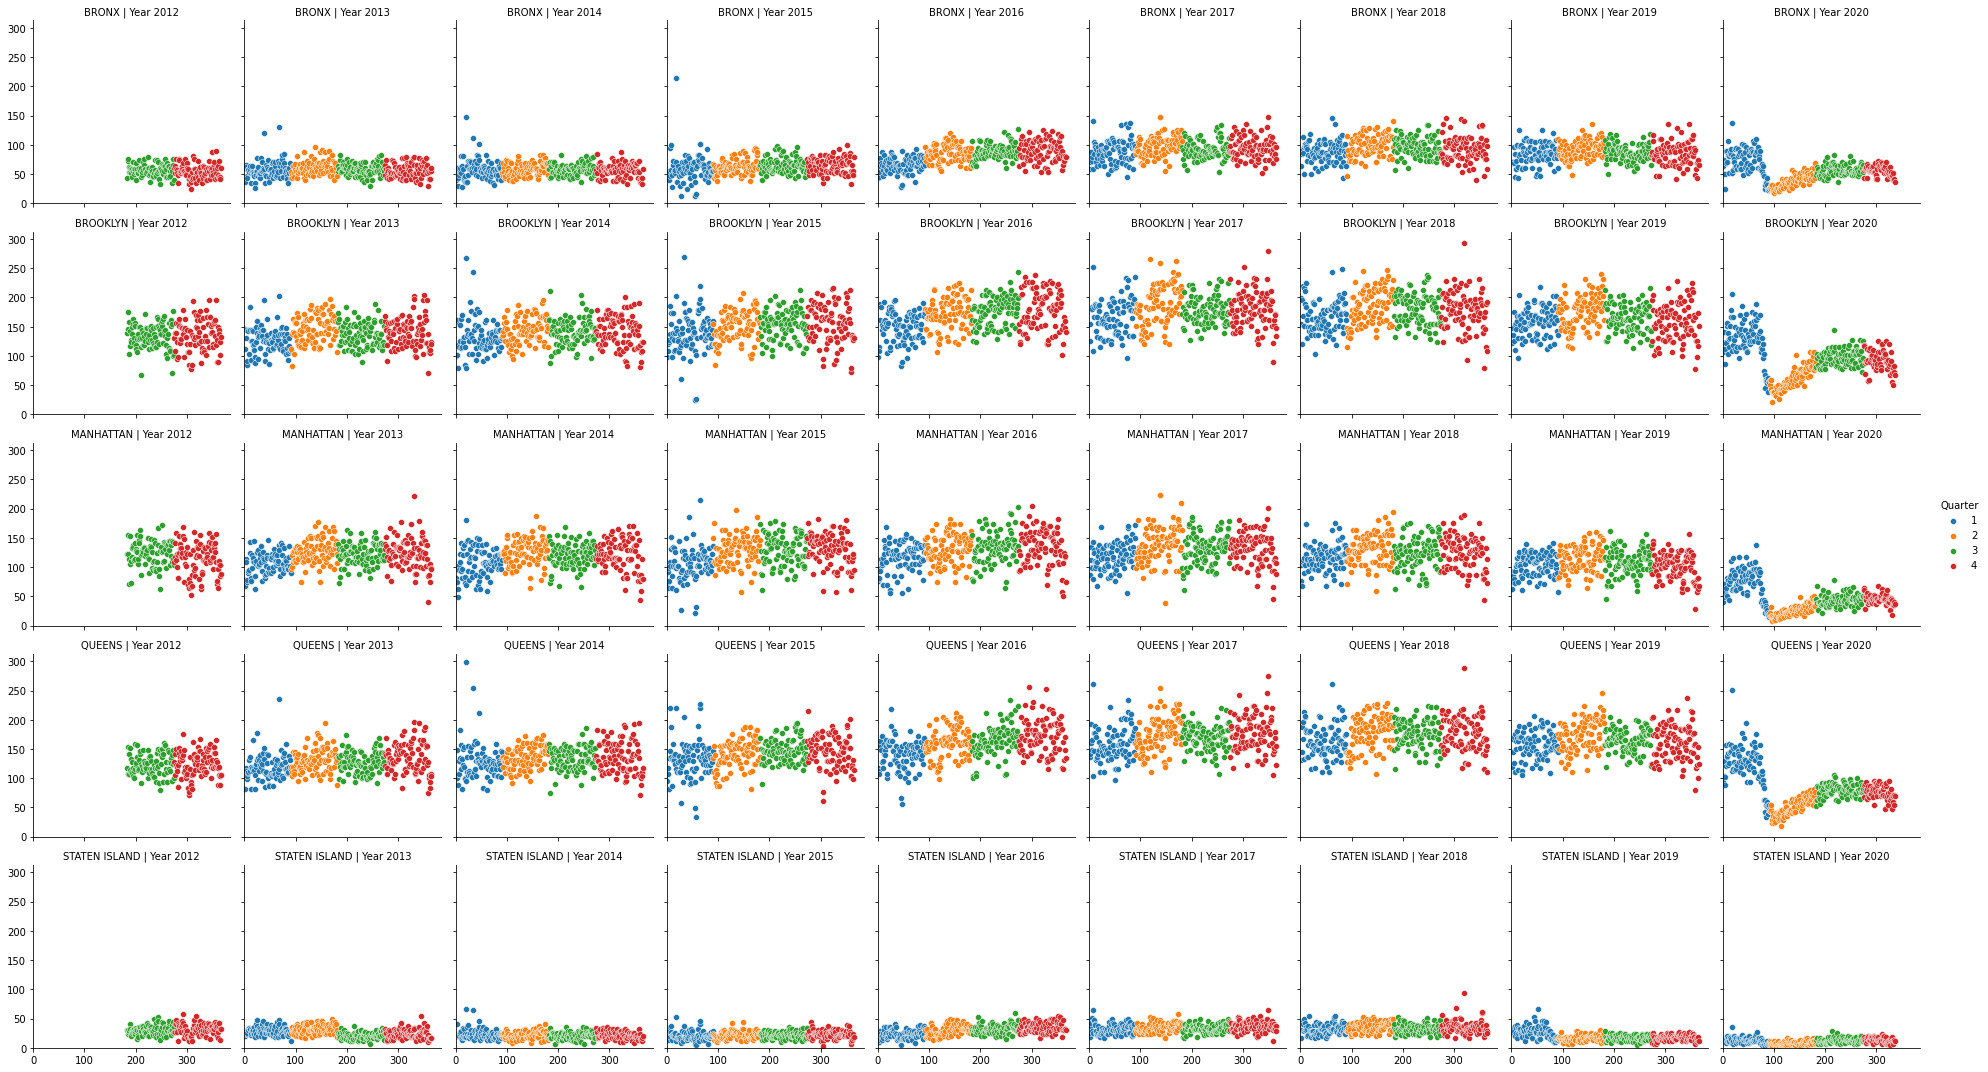

In [19]:
scatter_plot = collision_df3.copy()
scatter_plot['year'] = scatter_plot.index.year
scatter_plot['quarter'] = scatter_plot.index.quarter
scatter_plot['month'] = scatter_plot.index.month_name()
scatter_plot['day'] = scatter_plot.index.day_name()
scatter_plot['yearday_num'] = scatter_plot.index.dayofyear
scatter_plot['weekday_num'] = scatter_plot.index.dayofweek

scatter_plot = scatter_plot.melt(id_vars=['year', 'quarter', 'month', 'day', 'yearday_num', 'weekday_num'], value_vars=['BRONX', 'BROOKLYN','MANHATTAN','QUEENS','STATEN ISLAND'], var_name = 'borough', value_name = 'collisions')

g = sns.FacetGrid(scatter_plot, col = 'year', row = 'borough', hue='quarter', sharey=True)
g.map_dataframe(sns.scatterplot, x="yearday_num", y = 'collisions')
g.set_titles(col_template="Year {col_name}", row_template="{row_name}")
g.tight_layout()
g.add_legend(title="Quarter")
g.set(ylim=(0, None), xlim=(0, None))

The data from `complete_df` is plotted in a scatter for each day of the year, in a `FacetGrid` of plots by `year` and `borough`. The plots are highlighted by their annual `quartile`. Looking at the data in the scatter above, there are some odd discrepancies in  the years 2012 and 2020. 

2012 is the beginning year of the collision data, and only half the last 2 quartiles the year of data are recorded, beginning from July. Since a large portion of that year for each borough is missing the data will be dropped.

In 2020 the collision data is influenced by a global lockdown at the end of March, a very odd circumstance, due to the coronavirus of 2019. This will influence the results and so it will be dropped as well.

`STATEN ISLAND` also shows some odd trends, especially in 2013 and 2019. The other collisions for this borough do hold a similar trend but since they are more nebulous in distribution, and Staten Island accounts for the smallest portion of collisions, the borough will be dropped as well.  

A barchart based on collisions on the day of the week across the quartiles of the year, sorted by years and boroughs that should not be dropped in plotted below. 

In [ ]:
g = sns.FacetGrid(scatter_plot.drop(scatter_plot[(scatter_plot.year == 2012) | (scatter_plot.year == 2020) | (scatter_plot.borough == 'STATEN ISLAND')].index, axis=0), 
                  col = 'year', row = 'borough', sharey=True, height= 2, aspect= 2)
g.map_dataframe(sns.barplot, x='quarter', y = 'collisions', hue='day', palette="Spectral")
g.set_titles(col_template="Year {col_name}", row_template="{row_name}")
g.tight_layout()
g.add_legend(title="Quarter")
g.set(ylim=(0, None))

The year 2013 begins on a Tuesday which means the dataset begins on a Tuesday. Looking at the data it appears that collisions appear to increase with respect to the day of the week, from Sunday to Friday then drop downwards on a Saturday to Sunday to begin rising again. This can be fixed by sorting values by `weekday_num`, but the week begins on a Monday with a `0`.

The day of the week is starts with `Monday = 0` and ends with `Sunday = 6`. The data from the blue scatter/histogram further below shows a steady increase in collisions until Saturday and drops suddenly on Sunday, so in the interest of finding linear relationships the day numbers of the week will be shifted by one so that `Sunday = 0`, `Monday = 1`, and `Saturday = 6`.

In [ ]:
collision_df4 = collision_df3.drop('STATEN ISLAND', axis=1)
collision_df4.drop(collision_df4[(collision_df4.index.year == 2012) | (collision_df4.index.year == 2020)].index, inplace=True)
collision_df4.head()

### Removing the outlier data

To remove the outlier data an estimation can be made to contain the bulk of the data while removing obscure points.

The `describe()` function calculates the `percentiles` which can be describes. Since these are the method being proposed to describe the *working bandwidth* of data, any outlying data will be dropped. Setting the percentiles gives an element of control over the band with which to smooth the data by.

The values from the `describe()` function are saved into a dictionary based on `year` and `month` of the value.

In [ ]:
pets = {"Cat":"Feline Friend", "Dog": "Canine Friend"}

In [ ]:
pets['Dog']

In [ ]:
low_percentile = 10
high_percentile = 100 - low_percentile
df_stats = {}

for year in collision_df4.index.year.unique():
  df_stats[str(year)] = {}
  for month in collision_df4.index.month.unique():
    df_stats[str(year)][str(month)] = collision_df4[(collision_df4.index.year == year) & (collision_df4.index.month == month)].describe(percentiles = [low_percentile/100, .5, high_percentile/100])

print(f"""Stats for July 2013: 
{df_stats['2013']['7']}

Stats for July 2015: 
{df_stats['2015']['7']}

{low_percentile}% percentile for July 2015: 
{df_stats['2015']['7'].iloc[4]}

{low_percentile}% percentile for MANHATTAN in July 2015: 
{df_stats['2015']['7']['MANHATTAN'].iloc[4]}
""")

def trim_dataframe(data):
  for date in data.index:
    if df_stats[str(date.year)][str(date.month)][data.name].iloc[4] < data[date] < df_stats[str(date.year)][str(date.month)][data.name].iloc[6]:
      data[date] = data[date]
    else:
      data[date] = np.nan
  return data

collision_df5 = collision_df4.copy()
collision_df5 = collision_df5.apply(lambda x: trim_dataframe(x))

collision_df5.head()

The selected and outlier-trimmed scattered data now looks like:

In [ ]:
trim_plot = collision_df5.copy()
trim_plot['year'] = trim_plot.index.year
trim_plot['quarter'] = trim_plot.index.quarter
trim_plot['month'] = trim_plot.index.month_name()
trim_plot['day'] = trim_plot.index.day_name()
trim_plot['yearday_num'] = trim_plot.index.dayofyear
trim_plot['weekday_num'] = trim_plot.index.dayofweek
trim_plot['weekday_num'] = trim_plot['weekday_num'].apply(lambda x: 0 if x == 6 else x + 1)

trim_plot = trim_plot.melt(id_vars=['year', 'quarter', 'month', 'day', 'yearday_num', 'weekday_num'], value_vars=collision_df5.columns, var_name = 'borough', value_name = 'collisions')

In [ ]:
g = sns.FacetGrid(trim_plot, col = 'year', row = 'borough',hue='quarter', sharey=True)
g.map_dataframe(sns.scatterplot, x="yearday_num", y = 'collisions')
g.set_titles(col_template="Year {col_name}", row_template="{row_name}")
g.tight_layout()
g.add_legend(title="Quarter")
g.set(ylim=(0, None))
# g.set_xticklabels(rotation=0)

There are a couple of methods to 'normalize' the data. Three of which are:

1. **Normalization** is each data value divided by the maximum of that set. The data keeps its shape but is scaled down to between `0` and `1`.

 \begin{equation} x_{Norm} = \frac {x}{x_{max}} \end{equation}

2. **Feature Normalization** subtracts the minimum value from the data and then divides by the maximum data subtracted from the minimum data. This stretches the data to have the minimum data value set to `0` and the maximum set to `1`.

\begin{equation} x_{Feat.\ Norm} = \frac {x - x_{min}}{x_{max} - x_{min}} \end{equation}

3. **Standardization** subtracts the mean value and then divides by the standard deviation. This creates a normal distribution centred around `0` with the outlier data points leading off to `+ve` or `-ve` depending on the value being greater or less than the mean value. 

\begin{equation} x_{Standard} = \frac{x - \mu}{\sigma} = \frac{x - x_{mean}}{x_{std}} \end{equation}

In [ ]:
df_stats_norm = {}

for year in collision_df5.index.year.unique():
  df_stats_norm[str(year)] = {}
  for month in collision_df5.index.month.unique():
    df_stats_norm[str(year)][str(month)] = collision_df5[(collision_df5.index.year == year) & (collision_df5.index.month == month)].describe()

print(f"""Normalized stats for July 2012: 
{df_stats_norm['2013']['7']}

# Normalized stats for July 2015: 
# {df_stats_norm['2015']['7']}

# Minimum values for July 2015: 
# {df_stats_norm['2015']['7'].min}

# Minimum values for MANHATTAN in July 2015: 
# {df_stats_norm['2015']['7']['MANHATTAN'].min}
""")

def normalize_dataframe(data, norm_meth = 1):
  for date in data.index:
    if norm_meth == 1:
      data[date] = data[date] / df_stats_norm[str(date.year)][str(date.month)][data.name].loc['max'] # Course Normalization      
    elif norm_meth == 2:
      data[date] = (data[date] - df_stats_norm[str(date.year)][str(date.month)][data.name].loc['min']) / (df_stats_norm[str(date.year)][str(date.month)][data.name].loc['max'] - df_stats_norm[str(date.year)][str(date.month)][data.name].loc['min']) # Feature Normalization
    elif norm_meth == 3:
      data[date] = (data[date] - df_stats_norm[str(date.year)][str(date.month)][data.name].loc['mean']) / (df_stats_norm[str(date.year)][str(date.month)][data.name].loc['std']) # Standardisation 
  return data

collision_df6 = collision_df5.copy()
collision_df6 = collision_df6.apply(lambda x: normalize_dataframe(data = x, norm_meth = 2))

collision_df6.head()

The scatter plots above won't tell much since all the data has been normalized between `0` and `1`, or distributed evenly between a `+ve` and `-ve` value if using standardization.

Instead the data can be viewed using a barchart for days of the weeks across the quartiles between years and boroughs. Note, the day of the week was set to begin with Sunday to show the general trend of a gradual increase in collisions until Saturday where it begins to fall.

In [ ]:
norm_plot = collision_df6.copy()
norm_plot['year'] = norm_plot.index.year
norm_plot['quarter'] = norm_plot.index.quarter
norm_plot['month'] = norm_plot.index.month_name()
norm_plot['day'] = norm_plot.index.day_name()
norm_plot['yearday_num'] = norm_plot.index.dayofyear
norm_plot['weekday_num'] = norm_plot.index.dayofweek
norm_plot['weekday_num'] = norm_plot['weekday_num'].apply(lambda x: 0 if x == 6 else x + 1)

norm_plot = norm_plot.melt(id_vars=['year', 'quarter', 'month', 'day', 'yearday_num', 'weekday_num'], value_vars=['BRONX', 'BROOKLYN','MANHATTAN','QUEENS',], var_name = 'borough', value_name = 'collisions')

g = sns.FacetGrid(norm_plot.sort_values('weekday_num'), row = 'borough', col='year', sharey=False, height= 2, aspect= 2)
g.map_dataframe(sns.barplot, x='quarter', y = 'collisions', hue='day', palette="Spectral")
g.set_titles(col_template="Year {col_name}", row_template="{row_name}")
g.tight_layout()
g.add_legend()
g.set(ylim=(0, 1))

## Processing the Weather Data
The Weather data has largely been processed in the query. The only extra processing it may need is filling in null data and turning character/objects to floats.

The columns in the weather data and the key for missing values are:

Column name | Meaning | Missing Value
---|---|---
`year`, `mo`, and `da`| Year, Month, and day | -
`temp` |Mean Temperature in fahrenheit | `9999.9`
`dewp` |Mean Dew Point in fahrenheit | `9999.9`
`slp` |Sea Level Pressure in millibars  | `9999.9`
`visib` |Mean Visibility in Miles  | `999.9`
`wdsp` |Mean Wind Speed in knots  | `999.9`
`mxpsd` |Maximum sustained Wind Speed in knots  | `999.9`
`gust` |Maximum Wind Gust in knots  | `999.9`
`max` |Maximum Temperature in Fahrenheit | `9999.9`
`min` |Minimum Temperature in Fahrenheit | `9999.9`
`prcp` |Total Precipitation in inches | `99.99`
`sndp` |Snow depth in inches | `999.9`
`fog` |Yes = 1, No = 0 | -

And the head of the data frame looks like:

In [ ]:
weather_df.head()

The non-date data imported is set as a float with `astype(float)`. This is to make sure that the data is numerical and not character or object.

The recorded values are cleaned for the unavailable data and replaced with an `np.nan` value from the Numpy library. This is because some mathematical functions don't work properly with Python's standard `NoneType`. 

In [ ]:
weather_df.loc[:, 'temp':'fog'] = weather_df.loc[:, 'temp':'fog'].astype(float)
weather_df = weather_df.replace(9999.9, np.nan)
weather_df[['visib', 'wdsp', 'mxpsd', 'gust', 'sndp']] = weather_df[['visib', 'wdsp', 'mxpsd', 'gust', 'sndp']].astype(float).replace(999.9, np.nan)
weather_df['prcp'] = weather_df['prcp'].replace(99.99, np.nan)
weather_df.info()
print(f"{weather_df.value_counts('sndp')}, {weather_df.value_counts('fog')}")

Since there are only 4 days with snowdepth, `sndp`, and 2 states for `fog`, `0` or `1`, they will be dropped to simplify the dataset. 
The `da` is day of the month and this information at the scale the data is being viewed, without reference to the month, is largely just noise. If the day is a significant detail then it will be shown by the `date` column so the `da` will be dropped as well.

In [ ]:
weather_df2 = weather_df.drop(['sndp','fog','da'], axis=1)
weather_df2.describe()

## Combining Weather and Collisions
Both datasets are ready to be combined into one dataset by date.

The weather data starts in the first of January, 2012, but the collision data starts in the first of July, 2012. So the rows with `None` in collision count columns are dropped from the dataset, trimming the weather data.

The length of the dataset remains the same as `collision_df3`.

For ease, the date column has also been set to the index for the dataset.

In [ ]:
complete_df = pd.merge(weather_df2[(weather_df2.date >= collision_df6.index.min()) & (weather_df2.date <= collision_df6.index.max())], collision_df6, how="left", on=["date"])

complete_df.set_index('date', inplace = True)
complete_df = complete_df.astype(float)
complete_df[['year', 'mo']] = complete_df[['year', 'mo']].astype(int)
complete_df['quarter'] = complete_df.index.quarter 
complete_df['month'] = complete_df.index.month_name()
complete_df['day'] = complete_df.index.day_name()
complete_df['weekday_num'] = complete_df.index.dayofweek
complete_df['weekday_num'] = complete_df['weekday_num'].apply(lambda x: 0 if x == 6 else x + 1)

complete_df = complete_df[['year','quarter', 'mo', 'month', 'day', 'weekday_num','temp', 'dewp', 'slp', 'visib', 'wdsp', 'mxpsd', 'gust', 'max', 'min', 'prcp', 'BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS']]
complete_df.head()

## Viewing the collated weather and collision data

The Kernel Density Estimate (KDE) plot is similar to the histogram/scatter plot above, taking a bit longer to calculate but it's good at showing the trends of the data by giving contours to show where the most densly populated areas are. 



In [ ]:
plot_height = 3 # Set plot height
plot_aspect = 1 # Set plot aspect ratio

g = sns.PairGrid(data = complete_df, hue='quarter', palette="Spectral",
            x_vars = complete_df.drop(['year', 'quarter', 'mo', 'month', 'weekday_num', 'day'], axis=1).columns[:-4],
            y_vars = complete_df.drop(['year', 'quarter', 'mo', 'month', 'weekday_num', 'day'], axis=1).columns[-4:],
            height = plot_height, aspect = plot_aspect,
            )
g.map(sns.kdeplot)
g.add_legend(title='Quarter')

From the `KDE` plot of the `collisions` by `borough`, the sea level pressure `slp`, visibility `visib`, windspeed `wdsp`, maxwindspeed `mxpsd`, gust  `gust`, and precipitation `prcp` show little seasonality change by `quarter`. However the temperature `temp`, dew point `dewp`, maximum temperature `max`, and minimum temperature `min` show a strong seasonal variation which is to be expected with lower temperature values in winter than in summer. Below the plots are modelled by year and the suggested reason why will be discussed further. 

Using seaborn, a range of scatter/histogram plots can be made where the density of the scatter is shown by the shade of the plot. The more dense the scatter the darker the plot.

In [ ]:
g = sns.PairGrid(data = complete_df[complete_df.quarter < 3], hue='year', palette="Spectral",
            x_vars = complete_df.drop(['year', 'quarter', 'mo', 'month', 'weekday_num', 'day'], axis=1).columns[:-4],
            y_vars = complete_df.drop(['year', 'quarter', 'mo', 'month', 'weekday_num', 'day'], axis=1).columns[-4:],
            height = plot_height, aspect = plot_aspect, 
            )
g.map(sns.regplot,)
g.add_legend(title='Year')

In [ ]:
g = sns.PairGrid(data = complete_df[complete_df.quarter >= 3], hue='year', palette="Spectral",
            x_vars = complete_df.drop(['year', 'quarter', 'mo', 'month', 'weekday_num', 'day'], axis=1).columns[:-4],
            y_vars = complete_df.drop(['year', 'quarter', 'mo', 'month', 'weekday_num', 'day'], axis=1).columns[-4:],
            height = plot_height, aspect = plot_aspect, 
            )
g.map(sns.regplot,)
g.add_legend(title='Year')

### Selecting particular Year

In [ ]:
matrix = np.triu(complete_df.drop(['year', 'quarter', 'mo', 'month', 'weekday_num', 'day'], axis=1).corr())
fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(complete_df[complete_df.year == 2016].drop(['year', 'quarter', 'mo', 'month', 'weekday_num', 'day'], axis=1).corr(), mask=matrix, annot=True)

### Selecting particular Quartile in Year

In [ ]:
matrix = np.triu(complete_df.drop(['year', 'quarter', 'mo', 'month', 'weekday_num', 'day'], axis=1).corr())
fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(complete_df[(complete_df.year == 2017) & (complete_df.quarter == 1)].drop(['year', 'quarter', 'mo', 'month', 'weekday_num', 'day'], axis=1).corr(), mask=matrix, annot=True)

### Selecting particular Month

In [ ]:
matrix = np.triu(complete_df.drop(['year', 'quarter', 'mo', 'month', 'weekday_num', 'day'], axis=1).corr())
fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(complete_df[complete_df.month == 'January'].drop(['year', 'quarter', 'mo', 'month', 'weekday_num', 'day'], axis=1).corr(), mask=matrix, annot=True)

### Selecting particular day of the week

In [ ]:
# matrix = np.triu(complete_df.drop(['year', 'quarter', 'mo', 'month', 'weekday_num', 'day'], axis=1).corr())
fig, ax = plt.subplots(figsize=(10,5)) 
# sns.heatmap(complete_df[(complete_df.year == 2016) & (complete_df.quarter == 2) & (complete_df.weekday_num == 6)].drop(['year', 'quarter', 'mo', 'month', 'weekday_num', 'day'], axis=1).corr(), mask=matrix, annot=True)
sns.heatmap(complete_df[(complete_df.year == 2016) & (complete_df.quarter == 2) & (complete_df.weekday_num == 6)].drop(['year', 'quarter', 'mo', 'month', 'weekday_num', 'day'], axis=1).corr().iloc[-4:, :-4], annot=True)

### Plots with respect to year

The plot points can be shaded by year to give a perspective of how collisions compare by year.

The above plot shows collisions tending to increase until 2020 when they suddenly fall. The easiest explanation of this would be due to the coronavirus-2019 lockdowns that have been forcing people to stay and work from home which would lower traffic.

It might be worth while omitting the year 2020 from the dataset as an abnormal year for collisions.

The `regplot` function requires integer values so the object values of `month` and `day` cannot be included. `plot_df` is used instead. 

### Plots with respect to month

Looking at the data and highlighting it by `month` there  does appear to be a strong seasonal correlations with precipitation `prcp`, temperature `temp`, and `min`/`max` windspeeds.

From the `regplot`, there seems to be a strong relationship between spring/summer months and precipitation or warm weather, but in winter a colder temperature or lower windspeed tend to show higher collisions. 

### Plots with respect to Day of the Week (represented by a number)

A correlation plot shows how well  the collisions in the `boroughs` compare with the weather conditions.

This plot shows how the collision data is scattered with respect to the weather data and the year/month data.

### Correlation plot

In [ ]:
matrix = np.triu(plot_df3.corr())
fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(plot_df3[(plot_df3.year == 2015) & (4 < plot_df3.mo) & (plot_df3.mo < 8)].corr(), mask=matrix, annot=True)

## Creating Dummy Variables for One Hot Encoding

Two new columns are made for the name of the day and the name of the month. These values are turned into 'dummies', where the data is transferred to the header and the column is marked with an entry of `1` or `0` depending on that `date`. This is called One Hot Encoding and prepares string variables for modeling.

Once the Month and Day datasets have been encoded with dummy variables, they are merged together on their respective `date index`, before being merged with the main dataset, again by the `date index`.

In [ ]:
OHE_month_day = pd.merge(pd.get_dummies(complete_df6.month), pd.get_dummies(complete_df6.day), left_index=True, right_index=True)
OHE_complete_df = pd.merge(complete_df6.drop(['year', 'mo', 'month','day'], axis=1), OHE_month_day, left_index=True, right_index=True)
OHE_complete_df.head()

## Saving the dataset to Google Drive's `My Drive`

Now the data is prepared, it is ready to be saved. 
Running the code below saves the data to the user's google drive under `My Drive`. The string saying `Dataset Successfully Saved!` will notify the user that a copy of the dataset has been saved to their google drive. 

*(Unless changed above, `save_collision_data` will be `False`)*

In [ ]:
if save_collision_data:
  if not drive:
    from google.colab import drive
    drive.mount('drive')

  OHE_complete_df.to_csv('Tom_Blackwood-Weather_and_Collision_data_for_New_York_boroughs_2012-2020.csv')
  !cp Tom_Blackwood-Weather_and_Collision_data_for_New_York_boroughs_2012-2020.csv "drive/My Drive"
  print("Dataset Successfully Saved!")